In [28]:
import geopandas as gpd
import osmnx as ox
import xgboost as xgb
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,RandomForestClassifier
import time 
import pandas as pd
import matplotlib.pyplot as plt
from  sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix,f1_score,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score,accuracy_score

In [6]:
place_name="paris"
path=r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\osm\\"+place_name.lower()
dep=75

In [3]:
iris_data=pd.read_excel("Y:\REFERENTIEL DATA\RP 2022 FRANCE\GEODATA - IRIS\Geodata_IRIS_essentiels.xlsx").set_index('CODE_IRIS')
contour_iris=gpd.read_file(r'Y:\REFERENTIEL DATA\RP 2022 FRANCE\CARTOGRAPHIE\Cartographie_France_IRIS_2019\CONTOURS-IRIS_2-1_SHP_LAMB93_FXX-2019\CONTOURS-IRIS.shp').to_crs('EPSG:3857')
building=pd.read_pickle(path+r"\\raw data\\building.pkl").to_crs('EPSG:3857')

In [4]:
building_no_na=building[building['building']!="yes"]
building_na=building[building['building']=="yes"]

In [7]:
#get contours of Paris only 
dep_contour_iris=contour_iris[contour_iris['INSEE_COM'].isin([str(i) for i in range(dep*1000,(dep+1)*1000)])]

In [8]:
a=gpd.sjoin(building,dep_contour_iris,predicate="intersects",how="left")
a = a[~a.index.duplicated(keep='first')].reset_index()

In [9]:
iris_building_id=a[["index_right",'element_type',"osmid"]].copy()
iris_building_id=iris_building_id.set_index(['element_type',"osmid"])

In [10]:
a=gpd.GeoDataFrame(
    a[['element_type',"osmid","CODE_IRIS"]].merge(contour_iris[['CODE_IRIS',"geometry"]]),

).set_geometry("geometry").set_crs('EPSG:3857')

xx=gpd.sjoin(a,dep_contour_iris,predicate="touches")


In [11]:
nearby_buildings=xx[["osmid",'element_type',"CODE_IRIS_left","index_right"]].groupby(["element_type",'osmid'])['index_right'].apply(list)

In [12]:
nearby_buildings=nearby_buildings.to_dict()

In [16]:
building_no_na['building']=np.where(building_no_na['building'].isin(['apartments',"house","residential"]),1,0)

C:\Users\Diametrix\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [18]:
train,test =train_test_split(building_no_na,random_state=123)

# constant (mode)

In [17]:
building_no_na['building'].value_counts()

1    22547
0     5587
Name: building, dtype: int64

In [19]:
prediction=[train['building'].mode().values[0]]*len(test)

In [24]:
roc_auc_score(test['building'],prediction,average=None)

0.5

<Figure size 1440x1440 with 0 Axes>

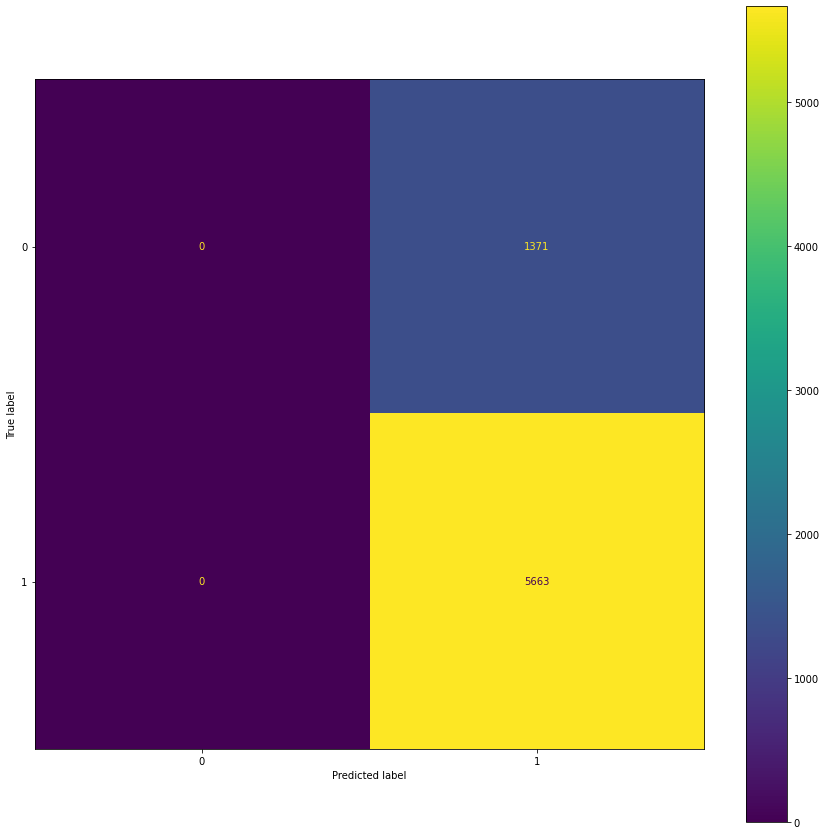

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,20))
p=ConfusionMatrixDisplay(confusion_matrix(test['building'],prediction))
p.plot()
fig = p.ax_.get_figure() 
fig.set_figwidth(15)
fig.set_figheight(15)  
plt.show()

# KNN -mode

In [44]:
prediction=[]
for k in [1,2,4,5,10]:
    prediction=[]
    print("K :",k)
    for i in range(len(test)):
        if i%2000==0:print(i)
        distances=building_no_na.distance(test.iloc[i]['geometry']).sort_values()

        distances=distances.drop(test.iloc[i:].index[0])
        prediction.append(building_no_na.loc[building_no_na.distance(test.iloc[i]['geometry']).sort_values().iloc[1:k+1].index,"building"].mode().values[0] )


    print("AUC :",roc_auc_score(test['building'],prediction,average=None))
    print("Accurcay :",accuracy_score(test['building'],prediction))

K : 1
0
2000
4000
6000
AUC : 0.8171915332523696
Accurcay : 0.8947967017344327
K : 2
0
2000
4000
6000
AUC : 0.8353200094848348
Accurcay : 0.858117713960762
K : 4
0
2000
4000
6000
AUC : 0.7755395336897745
Accurcay : 0.867785044071652
K : 5
0
2000
4000
6000
AUC : 0.7330305630892844
Accurcay : 0.8758885413704862
K : 10
0
2000
4000
6000
AUC : 0.7085997723072968
Accurcay : 0.8628092123969292


<Figure size 1440x1440 with 0 Axes>

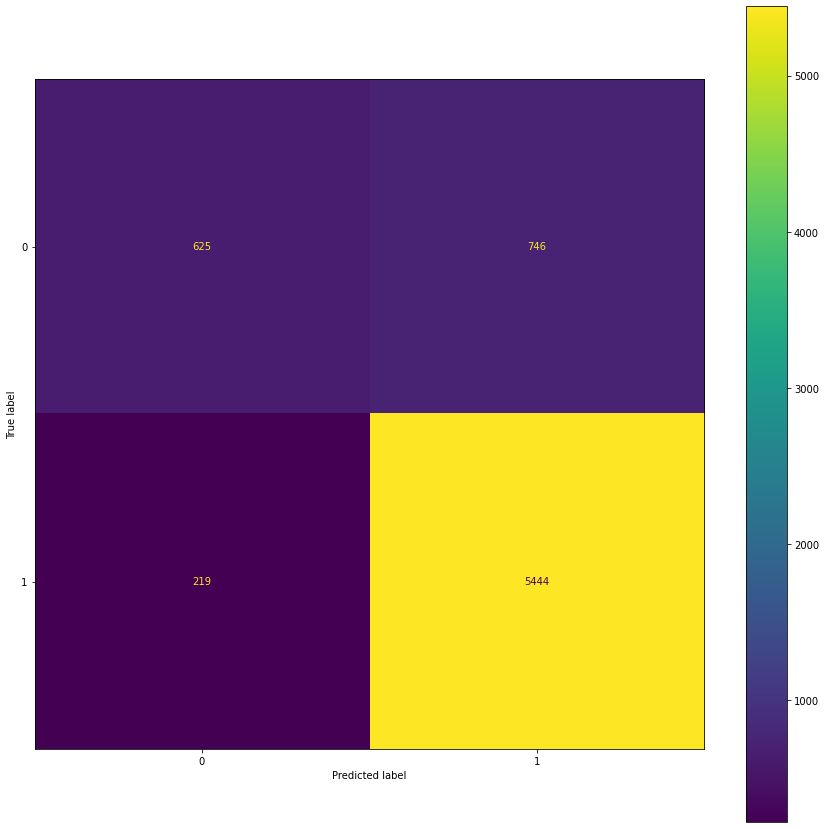

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,20))
p=ConfusionMatrixDisplay(confusion_matrix(test['building'],prediction))
p.plot()
fig = p.ax_.get_figure() 
fig.set_figwidth(15)
fig.set_figheight(15)  
plt.show()